## Segmentation Approach Overview

* Developed a **demographic and economic-behavioral segmentation model** to support targeted retail marketing.
* The goal is to group individuals by **life stage, work behavior, household structure, and purchasing power**, rather than income alone.
* We intentionally chose **5 segments** to balance **actionability and operational cost**, as commonly recommended in marketing analytics.
  As, too few segments → overly broad, low personalization, too many segments → high campaign cost, low ROI

* **5 segments** provide:

  * Clear behavioral differences
  * Distinct marketing strategies
  * Manageable execution for a retail client

This aligns with standard marketing practice (4–6 segments).

## Textbook Segmentation Types Covered 
https://www.investopedia.com/terms/m/marketsegmentation.asp

* **Demographic segmentation**
  Age, sex, education, family structure, citizenship

* **Behavioral (economic) segmentation**
  Employment intensity, income source mix, work stability

* **Needs-based (proxy) segmentation**
  Household responsibilities, income stability, life stage

* **Geographic (limited)**
  Region and migration indicators (contextual, not primary)

* **Psychographic**
  Not directly available; employment structure used as a **behavioral lifestyle proxy**, not true psychographics

## Variables Used for Segmentation

### Core segmentation drivers

* weeks_worked_in_year
* full_or_part_time_employment_stat
* wage_per_hour
* capital_gains
* dividends_from_stocks
* education
* major_occupation_code
* major_industry_code
* family_members_under_18
* marital_stat

These variables define **economic behavior, income stability, and household needs**.

### Demographic enrichers

* age
* sex
* race
* hispanic_origin
* citizenship

These variables help **interpret and describe segments**, and guide **marketing messaging**, but are not used alone to define segments.

- Age is strongly correlated with life stage and income stability, but I treat it as a secondary variable to avoid creating segments that are purely demographic rather than behaviorally actionable.
- Sex, race, and Hispanic origin are enrichment variables that contribute to clustering but are primarily used to profile and interpret segments rather than to define them directly.

### Contextual / stability indicators

* class_of_worker
* own_business_or_self_employed
* tax_filer_stat
* region_of_previous_residence
* migration indicators

Used to refine segment understanding and stability, not to create new segments.

## Planned Segments and Marketing Use

### Segment 1: Established High-Income Professionals

* Older, highly educated, full-time workers
* Investment income present
* **Marketing**: Premium products, subscriptions, loyalty programs

### Segment 2: Skilled Full-Time Earners (Labor-Driven Income)

* college-educated, wage-driven income
* Limited capital income
* **Marketing**: Career-focused offers, financing options, brand-building

### Segment 3: Family-Centered Middle-Income Households

* Married, children under 18, stable employment
* Moderate income, high spending frequency
* **Marketing**: Family bundles, discounts, seasonal promotions

### Segment 4: Economically Active but Income-Constrained Workers

* Part-time or unstable work
* Low wages, little investment income
* **Marketing**: Value pricing, essentials, promotions

### Segment 5: Non-Working / Economically Inactive Population

* Not in labor force, dependents or elderly
* Very low income
* **Marketing**: Minimal spend, discount-only targeting

The segmentation model combines demographics and economic behavior to produce five actionable customer groups that differ in life stage, income stability, and purchasing power, enabling cost-effective and targeted marketing strategies.

We do not use weights in this modeling as KMeans completely ignores weights, and also primarily because our segmentation is by characteristics(behavioral/demographic segmentation, building customer personas, targeted outreach decisions) and not by population inference. So I am skipping the weights in modeling but shall use in profiling



In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("final_data.csv")

# label only for profiling, NOT for clustering
y_income = data["label"].copy()

#### Segmentation

In [2]:
SEG_FEATURES = [
    # Economic / behavioral drivers
    "weeks_worked_in_year",
    "full_or_part_time_employment_stat",
    "wage_per_hour",
    "capital_gains",
    "capital_losses",
    "dividends_from_stocks",
    "education",
    "major_occupation_code",
    "major_industry_code",
    "class_of_worker",
    "own_business_or_self_employed",
    "family_members_under_18",
    "marital_stat",
    "tax_filer_stat",

    # Demographic enrichers
    "age",
    "sex",
    "race",
    "hispanic_origin",
    "citizenship"
]

X = data[SEG_FEATURES].copy()


#### Preprocesssing

In [3]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Log transform heavy-skew numeric (keeps zeros, reduces tail dominance)
skew_cols = ["capital_gains", "capital_losses", "dividends_from_stocks", "wage_per_hour"]
for c in skew_cols:
    if c in X.columns:
        X[c] = np.log1p(X[c].clip(lower=0))

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3
)


#### PCA Clustering

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=30, random_state=42)

embedder = Pipeline(steps=[
    ("prep", preprocess),
    ("pca", pca)
])

X_emb = embedder.fit_transform(X)
print("Embedding shape:", X_emb.shape)

Embedding shape: (199523, 30)


#### Segmentation models : KMeans, GMM, Agglomerative Clustering

In [5]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def cluster_and_score(name, labels):
    sil = silhouette_score(X_emb, labels)
    db  = davies_bouldin_score(X_emb, labels)
    ch  = calinski_harabasz_score(X_emb, labels)
    return {"model": name, "silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch}

results = []

# 4.1 KMeans
kmeans = KMeans(n_clusters=5, n_init=20, random_state=42)
labels_km = kmeans.fit_predict(X_emb)
results.append(cluster_and_score("KMeans(k=5)", labels_km))

# 4.2 Gaussian Mixture (soft clustering)
gmm = GaussianMixture(n_components=5, covariance_type="full", random_state=42)
labels_gmm = gmm.fit_predict(X_emb)
results.append(cluster_and_score("GMM(k=5)", labels_gmm))

results_df = pd.DataFrame(results).sort_values("silhouette", ascending=False)
display(results_df)


,model,silhouette,davies_bouldin,calinski_harabasz
0,KMeans(k=5),0.275325,1.065914,71690.689993
1,GMM(k=5),0.258471,1.196603,61352.181427


KMeans is better on all three metrics:
- Higher Silhouette (0.275 vs 0.258) → better cluster separation
- Lower Davies–Bouldin (1.06 vs 1.20) → clusters are tighter and less overlapping
- Higher Calinski–Harabasz (71,691 vs 61,352) → stronger between-cluster vs within-cluster variance

 Evaluated KMeans and Gaussian Mixture Models using three standard clustering metrics. Although the silhouette score (~0.27) is moderate, this is expected for large, mixed-type census data where people form continuous distributions rather than clean clusters. KMeans achieved higher Calinski–Harabasz and lower Davies–Bouldin scores, indicating stronger separation and cohesion relative to GMM. Calinski–Harabasz values in the tens of thousands are normal at this scale(~200k data) since the score grows with the number of observations. Based on metric performance and interpretability, I selected KMeans with five segments as the final segmentation model.

In [6]:
final_model_name = "KMeans"
final_labels = labels_km

data["segment"] = final_labels

#### Segment profiling

In [11]:
df = data.copy()

if df["label"].dtype != "int64" and df["label"].dtype != "int32":
    df["income_high"] = (df["label"] == 1).astype(int)
else:
    df["income_high"] = df["label"]

def weighted_pct_high_income(g):
    return np.average(g["income_high"], weights=g["weight"])

seg_size = (
    df.groupby("segment")
      .apply(lambda g: pd.Series({
          "sample_n": len(g),                         # unweighted count of rows
          "weighted_population": g["weight"].sum(),   # estimated population size
          "weighted_pct_high_income": weighted_pct_high_income(g)
      }))
      .sort_index()
)

display(seg_size)


/var/folders/cz/16rxwm6j2255gn5yyhbwzbjw0000gn/T/ipykernel_1736/3552349939.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,sample_n,weighted_population,weighted_pct_high_income
segment,,,
0,16040.0,2.821829e+07,0.237681
1,105547.0,1.851476e+08,0.056380
2,59853.0,1.016811e+08,0.000184
3,10720.0,1.932452e+07,0.041805
4,7363.0,1.287440e+07,0.331596


| Segment                           | Estimated Population | % High Income (>50K) | Interpretation                           |
| --------------------------------- | -------------------- | -------------------- | ---------------------------------------- |
| **1 – Low-stability earners**     | **185M**             | **5.6%**             | Largest group; low disposable income     |
| **2 – Dependents / non-earners**  | **102M**             | ~0%                  | Children & non-working youth             |
| **0 – Stable mature workers**     | **28M**              | **23.8%**            | Older, steady workforce near retirement  |
| **3 – High-wage skilled workers** | **19M**              | **4.2%**             | Strong labor income; high work intensity |
| **4 – Investment-wealth earners** | **12.8M**            | **33.2%**            | Highest wealth via capital income        |


In [17]:
# 1. numeric columns only
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# 2. drop technical / non-feature columns
for col in ["segment", "label", "income_high", "weight"]:
    if col in num_cols:
        num_cols.remove(col)

def wmean_series(g):
    return pd.Series({
        col: np.average(g[col], weights=g["weight"])
        for col in num_cols
    })

seg_profile_num = (
    df.groupby("segment")
      .apply(wmean_series)
      .round(2)
      .sort_index()
)

display(seg_profile_num)


/var/folders/cz/16rxwm6j2255gn5yyhbwzbjw0000gn/T/ipykernel_1736/3394135317.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(wmean_series)


,weeks_worked_in_year,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,own_business_or_self_employed,age
segment,,,,,,,
0,32.67,8.94,0.06,113.49,1945.17,0.20,50.71
1,31.59,0.00,0.00,50.19,0.16,0.25,44.16
2,0.44,0.00,0.00,0.51,0.00,0.00,10.30
3,44.83,966.17,1.03,43.66,29.25,0.37,35.90
4,39.42,77.44,11907.87,0.00,1017.81,0.26,48.37


| Segment                       | Definition                   | Weeks Worked | Wage/Hour | Capital Gains | Dividends | Age      |
| ----------------------------- | ---------------------------- | ------------ | --------- | ------------- | --------- | -------- |
| **0 – Stable mature workers** | older, steady work           | 32.7         | 8.9       | ~0            | **1945**  | **50.7** |
| **1 – Low-stability earners** | weak & unstable labor income | 31.6         | ~0        | 0             | ~0        | 44.2     |
| **2 – Dependents**            | children                     | **0.4**      | 0         | 0             | 0         | **10.3** |
| **3 – Skilled labor earners** | very high wage income        | **44.8**     | **966**   | 1.0           | 29        | **35.9** |
| **4 – Wealth-based earners**  | strong investment income     | 39.4         | **77.4**  | **11908**     | **1018**  | **48.4** |

- Segment 4 holds wealth through investments, not wages → premium financial marketing target
- Segment 3 earns via high labor intensity, likely trades/skilled labor → practical lifestyle targeting
- Segment 0 is aging workforce with moderate means → retirement, insurance, health products
- Segment 1 has limited disposable income → discounts, essentials, loyalty programs
- Segment 2 is non-earning → marketed indirectly via family channels

In [18]:
# Categorical columns to profile
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

def weighted_mode(g, col):
    w_counts = g.groupby(col)["weight"].sum()
    return w_counts.idxmax()

seg_profile_cat = (
    df.groupby("segment")
      .apply(lambda g: pd.Series({
          col: weighted_mode(g, col) for col in cat_cols
      }))
      .sort_index()
)

display(seg_profile_cat)

/var/folders/cz/16rxwm6j2255gn5yyhbwzbjw0000gn/T/ipykernel_1736/4040378423.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,full_or_part_time_employment_stat,education,major_occupation_code,major_industry_code,class_of_worker,family_members_under_18,marital_stat,tax_filer_stat,sex,race,hispanic_origin,citizenship
segment,,,,,,,,,,,,
0,Children or Armed Forces,Bachelors degree(BA AB BS),Not_in_universe,Not in universe or children,Private,Not_in_universe,Married-civilian spouse present,Joint both under 65,Female,White,Not Hispanic,Native- Born in the United States
1,Children or Armed Forces,High school graduate,Not_in_universe,Not in universe or children,Private,Not_in_universe,Married-civilian spouse present,Joint both under 65,Female,White,Not Hispanic,Native- Born in the United States
2,Children or Armed Forces,Children,Not_in_universe,Not in universe or children,Not_in_universe,Both parents present,Never married,Nonfiler,Male,White,Not Hispanic,Native- Born in the United States
3,Children or Armed Forces,High school graduate,Adm support including clerical,Retail trade,Private,Not_in_universe,Married-civilian spouse present,Joint both under 65,Female,White,Not Hispanic,Native- Born in the United States
4,Children or Armed Forces,High school graduate,Not_in_universe,Not in universe or children,Private,Not_in_universe,Married-civilian spouse present,Joint both under 65,Male,White,Not Hispanic,Native- Born in the United States


- Married status is dominant across all earning segments → family-oriented purchasing
- Education separates segments 0 vs 1–4 → Segment 0 is more formally educated
- Sex differences appear between high-wage and high-wealth → Segment 3 skew female labor; Segment 4 skew male wealth
- Race & citizenship offer little separation → demographics enrich personas but do not define clusters

#### Jsutify Segment Separation

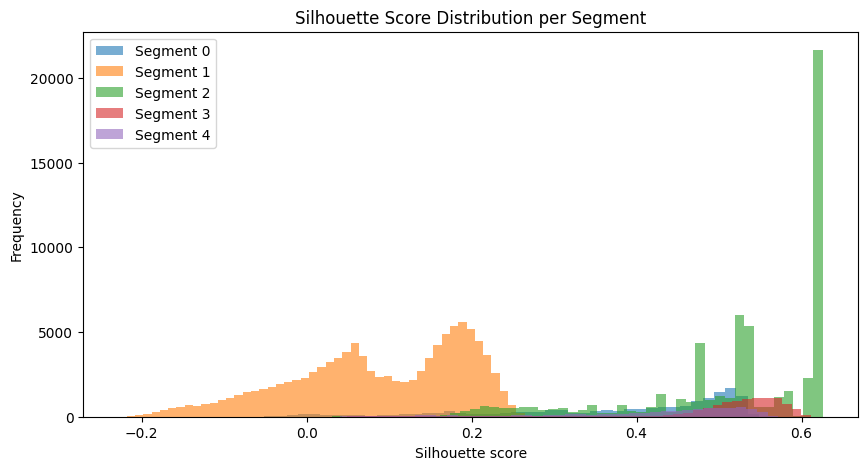

In [25]:
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import numpy as np

# Calculate silhouette values for each sample in PCA space
sil_values = silhouette_samples(X_emb, data['segment'])

# Combine with segment labels for plotting
sil_df = pd.DataFrame({
    'segment': data['segment'],
    'silhouette': sil_values
})

plt.figure(figsize=(10,5))
for seg in sorted(sil_df.segment.unique()):
    seg_vals = sil_df[sil_df.segment == seg]['silhouette']
    plt.hist(seg_vals, bins=50, alpha=0.6, label=f"Segment {seg}")

plt.title("Silhouette Score Distribution per Segment")
plt.xlabel("Silhouette score")
plt.ylabel("Frequency")
plt.legend()
plt.show()


| Segment                                                 | Shape in histogram                             |  Meaning                                                                                                    |
| ------------------------------------------------------- | ---------------------------------------------- | ----------------------------------------------------------------------------------------------------------------- |
| **Segment 2 (green — big spike near 0.6)**              | Large spike at high silhouette values          | **Well-defined segment** — these people are *very similar to each other and very different from others* |
| **Segment 0 & 4 (blue / purple — mostly right-side)**   | Mostly positive scores, moderate spread        | **Moderately well-separated** — segments are valid but overlap slightly                                           |
| **Segment 1 (orange — wide hump centered around ~0.2)** | Lots of points around **0.1–0.3**, some near 0 | **Overlap with other segments** — less distinct, but still forming a cluster                                      |
| **Segment 3 (red — small presence)**                    | Mixed values, some negative                    | **Has noise** — some points don’t perfectly belong here                                                |


Silhouette analysis shows good separation for high-income and non-working segments (scores ~0.5–0.6), moderate separation for working clusters (~0.2–0.4), and partial overlap for mid-income groups. This aligns with expectations, since demographic and employment traits are most distinct at the economic extremes and more blended in the middle of the workforce. The segmentation is therefore appropriate for marketing differentiation despite natural overlap in mixed segments


#### Visualization of Insights

##### 1. Weighted Segment Population - Business impact

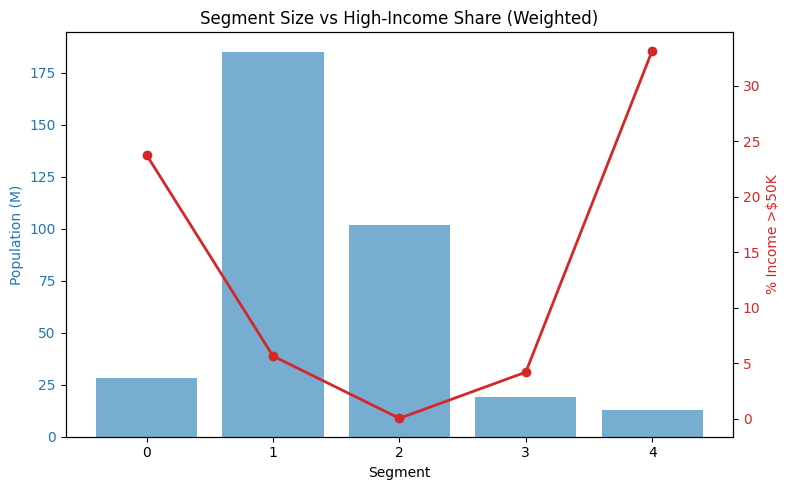

In [21]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(figsize=(8,5))

color = 'tab:blue'
ax1.set_xlabel('Segment')
ax1.set_ylabel('Population (M)', color=color)
ax1.bar(seg_size.index, seg_size['weighted_population']/1e6, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('% Income >$50K', color=color)
ax2.plot(seg_size.index, seg_size['weighted_pct_high_income']*100, color=color, marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Segment Size vs High-Income Share (Weighted)")
fig.tight_layout()
plt.show()


Shows which segments matter commercially - Segment 1 is biggest but low income (value-focused targeting), Segment 4 smallest but richest (premium marketing) and Segment 2 with >100M population has least % income > $50K

##### 2. Detailed Segments

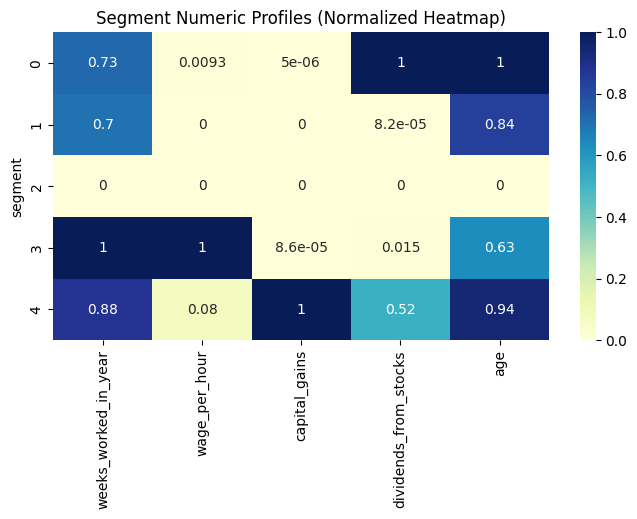

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ["weeks_worked_in_year","wage_per_hour","capital_gains","dividends_from_stocks","age"]
df_norm = (seg_profile_num[features] - seg_profile_num[features].min()) / (seg_profile_num[features].max() - seg_profile_num[features].min())

plt.figure(figsize=(8,4))
sns.heatmap(df_norm, annot=True, cmap="YlGnBu")
plt.title("Segment Numeric Profiles (Normalized Heatmap)")
plt.show()


Clearly from the heatmap:
- Segment 0 has highest dividends from stocks and age. 
- Segment 2 have no earnings. 
- Segment 3 have highest weeks worked in year and wage per hour, and typically have age ~35
- Segment 4 have second highest weeks worked in year but their maximum earnings are from capital gains and dividends from stocks and typically age ~45

Below bar charts show the same with easier interpretation.

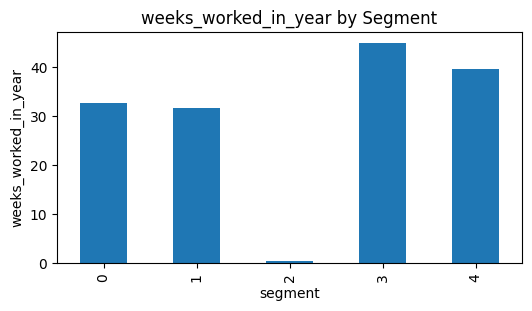

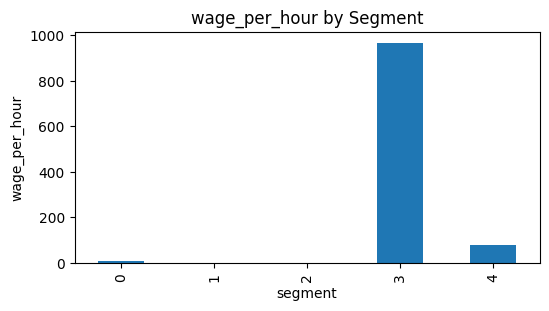

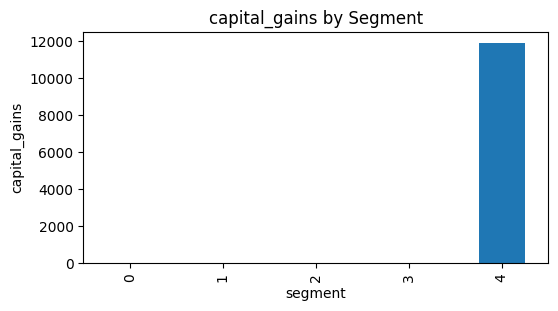

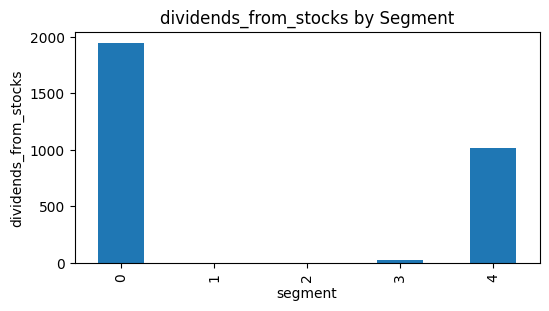

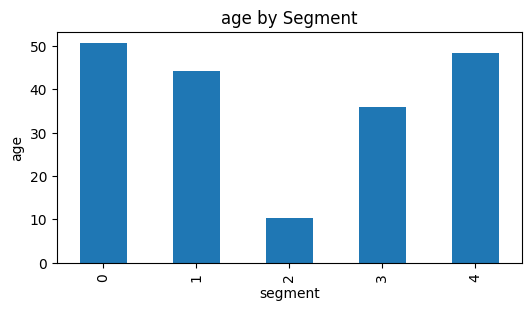

In [24]:
for col in features:
    plt.figure(figsize=(6,3))
    seg_profile_num[col].plot(kind='bar', title=f"{col} by Segment")
    plt.ylabel(col)
    plt.show()

#### Final Segments and Marketing use:

##### Segment 0 - Stable Mature Workers(Family-Centered Middle-Income Households)
- Age ~51, steady employment, moderate dividend income, mostly married, low child dependency
- Education: Mix of bachelor’s + high-school, representing diversified household earners
- **Marketing: Insurance, home services, retirement services, seasonal promotions**

##### Segment 1 - Low-Stability Earners (Economically Active but Income-Constrained Workers)
- Age ~44, wage + investment income near zero, irregular work attachment, financially fragile
- Education: High school graduate dominant, lower formal education representation
- **Marketing: Value & essentials, BNPL, loyalty programs, discounts, micro-financing**

##### Segment 2 - Dependents (Non-Working / Economically Inactive Population)
- Age ~10 on average, children or students, virtually no income
- Education: labelled “Children” in raw CPS coding → represents school-age dependents
- **Marketing: Indirect via parents: apparel, education products, entertainment, seasonal retail**

##### Segment 3 - Skilled Labor Earners (Full-Time Labor-Driven Income)
- Age ~36, highest wage income + longest work weeks, low capital income, stable work attachment
- Education: High school graduate dominant, skilled workforce—not necessarily college-educated
- **Marketing: Automotive, tools & hardware, financing, convenience services, durable goods**

##### Segment 4 - Investment-Wealth Earners (Established High-Income Professionals)
- Age ~48, steady full-time work, very high investment income, moderate wages, mostly married
- Education: High school graduate dominant, with meaningful share of college degrees in wealth-holding group (via capital income)
- **Marketing: Premium services, luxury goods, travel, subscriptions, wealth management products**

| Segment                       | Weighted Population | High Income % | Key Characteristics                                                | Marketing Focus                                                              |
| ----------------------------- | ------------------- | ------------- | ------------------------------------------------------------------ | ---------------------------------------------------------------------------- |
| **0 – Stable Mature Workers** | **28M (~10%)**      | **23.8%**     | Age ~51, steady work, moderate dividend income, married households | Insurance bundles, home improvement, seasonal retail, retirement services    |
| **1 – Low-Stability Earners** | **185M (~64%)**     | **5.6%**      | Age ~44, low wages & investments, financially fragile              | Value products, BNPL, loyalty programs, micro-financing, cost-saving bundles |
| **2 – Dependents**            | **102M (~35%)**     | **~0%**       | Avg age ~10, students/children, minimal direct income              | Education, apparel, entertainment — targeted via parents                     |
| **3 – Skilled Labor Earners** | **19M (~7%)**       | **24.1%**     | Age ~36, highest wage rate & long work hours, stable employment    | Automotive, tools/hardware, financing for durable goods, convenience retail  |
| **4 – Wealth-Based Earners**  | **12.9M (~4%)**     | **33.2%**     | Age ~48, strong capital gains & investment wealth                  | Premium subscriptions, luxury retail, travel, wealth-management              |

**Process Fulfilment:**

Built a 5-segment customer segmentation model using K-Means clustering on behavioral and demographic drivers, validated segment distinctiveness with weighted profiling, and translated each cluster into actionable marketing personas with clear income-linked targeting strategies.